# Spotting Outliers from Neutron Detection Background 


In our previous notebook, Eljen-Background-Characterization, we demonstrated how to verify that our neutron-count background is statistically stable over long runs. In this standalone notebook, we’ll go further by turning our focus to the problem of identifying individual neutron bursts that rise far above the expected background level. We will do this in two ways: 

1. **Naive Z-Score Test**
    
    We start with the familiar normal‐approximation to the Poisson distribution. For a process with mean rate $\lambda$ and $\sigma = \sqrt{\lambda}$, any one-minute count exceeding $\lambda + Z \cdot \sqrt{\lambda}$ is flagged as a Z-sigma outlier. This is quick and easy (see Knoll, Radiation Detection and Measurement, 4th ed., Wiley 2010), but it treats each minute in isolation.



2. **Family-Wise Error Control (Bonferroni)**  

    When you scan a long time series—say, a 24-hour background run divided into $N$ one-minute intervals—each interval represents a separate hypothesis test (“is this minute an outlier?”).  Even with a stringent per-test threshold, the sheer number of tests makes false alarms almost inevitable.  Specifically, scanning $N$ independent minutes at a fixed per-test $\alpha$ gives  
   $$
   \mathrm{FWER} = 1 - (1-\alpha)^N \approx N\alpha \quad(\text{for small }\alpha).
   $$
   Over a full day ($N \approx 1440$) using a 3 σ cut ($\alpha \approx 0.00135$) yields  
   $$
   \mathrm{FWER} \approx 1440 \times 0.00135 \approx 1.94,
   $$
   meaning you’re almost certain to see at least one (andon average 1.94) “false” outlier(s) purely by chance.  

   To counteract this effect of a long measurement period, we apply the **Bonferroni correction**, which adjusts the per-test significance level to  
   $$
   \alpha_{\rm per} = \frac{\alpha_{\rm family}}{N},
   $$
   ensuring  
   $$
   \mathrm{FWER} \le N \times \alpha_{\rm per} = \alpha_{\rm family}.
   $$  
   For example, to keep $\mathrm{FWER}=0.05$ over $N=1440$ minutes,  
   $$
   \alpha_{\rm per} = \frac{0.05}{1440} \approx 3.5\times10^{-5},
   $$
   corresponding to an **adjusted threshold**  
   $$
   Z_{\rm adj} \;=\;\Phi^{-1}\!\Bigl(1-\tfrac12\,\alpha_{\rm per}\Bigr)\;\approx\;4.0,
   $$
   i.e.\ roughly a 4 σ cut instead of 3 σ, which compensates for the extended duration of the measurement.

# Step 0 - Gathering Data and Distribution Characterization

As in our Eljen background–characterization study, we begin by importing the raw neutron‐count data and extracting its key statistical properties. In this step, we:
- Load the time‐series dataset of background counts.
- Visualize the count distribution to confirm its Poisson‐like behavior.

With these baseline statistics in hand, we’ll be ready to spot any bursts that deviate from the expected background.

For more detail on this data-collection, please refer to the "Eljen-Background-Characterization" notebook. 

In [5]:
# RUN THIS IF YOU ARE LOCAL. 
# It makes sure we can import helpers from libs which is one level up

import sys
import os

# Get the parent directory (one level up from the current directory)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the parent directory to sys.path
sys.path.insert(0, project_root)

In [6]:
# Libraries and helper functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import ipywidgets as widgets
from IPython.display import display

from IPython.display import Image
from IPython.display import Video
from IPython.display import HTML

# Use our custom helper functions
# - process_data
# - plot_panels
# - plot_panels_with_scatter
# - print_info
from libs.helpers import *

In [7]:
meta = {
    "descriptor" : "Eljen 2 inch 12-2024" # This will go into the title of all plots
}

In [8]:
neutron_df = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/eljen-2inch-long-term-1.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

gamma_df = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/eljen-2inch-long-term-4.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

In [13]:
neutron_df_1_minute = neutron_df.resample('1min').sum()
gamma_df_1_minute = gamma_df.resample('1min').sum()

# Assuming neutron_df_1_minute has a datetime index
start_time = "2024-12-19 00:00:00"
end_time = "2025-01-23 23:59:00"

neutron_df_1_minute_background = neutron_df_1_minute.loc[start_time:end_time]
gamma_df_1_minute_background = gamma_df_1_minute[start_time:end_time]

# Ensure the index is datetime
neutron_df_1_minute_background.index = pd.to_datetime(neutron_df_1_minute_background.index)

# Group by day
grouped_by_day = neutron_df_1_minute_background.groupby(neutron_df_1_minute_background.index.date)


# Define bins for the histogram
bins = np.arange(neutron_df_1_minute_background["Counts"].min(),
                 neutron_df_1_minute_background["Counts"].max() + 1, 1)  # Use integer bins

histograms = []
for day, group in grouped_by_day:
    hist_values, bin_edges = np.histogram(group["Counts"], bins=bins, density=True)
    histograms.append(hist_values)

# Convert list to array and compute mean + std across days
histograms = np.array(histograms)
mean_histogram = np.mean(histograms, axis=0)
std_histogram = np.std(histograms, axis=0)

# Estimate Poisson background mean
lambda_ = neutron_df_1_minute_background["Counts"].mean()
threshold_3sigma = lambda_ + 3 * np.sqrt(lambda_)

## Step 1 - Zooming in on outliers through naive Z-test

Once we have established the stability of background, we are interested in determining whether any specific neutron burst is "significantly high". To do this, we use the well-established normal approximation to the Poisson distribution.

Given a Poisson process with mean rate $ \lambda $, the standard deviation is $ \sqrt{\lambda} $. Under this approximation, an observed count is considered statistically significant at Z standard deviations if:

$$ \text{Count} > \lambda + Z \cdot \sqrt{\lambda}$$

This method is commonly used in radiation measurement and other count-based detection systems, as detailed in:

- G. F. Knoll, *Radiation Detection and Measurement*, 4th ed., Wiley, 2010.

In [17]:
# Function to update the plot based on Z
def plot_outliers(Z):
    threshold_poisson = lambda_ + Z * np.sqrt(lambda_)
    poisson_outliers = neutron_df_1_minute_background[neutron_df_1_minute_background["Counts"] > threshold_poisson]

    plt.figure(figsize=(14, 5))
    plt.plot(neutron_df_1_minute_background.index, neutron_df_1_minute_background["Counts"],
             label="Counts per Minute", color='blue', linewidth=1)

    plt.scatter(poisson_outliers.index, poisson_outliers["Counts"],
                color='red', label=f"Outliers (> {threshold_poisson:.2f} counts)", zorder=5)

    plt.axhline(threshold_poisson, color='gray', linestyle='--', linewidth=1.5,
                label=f"Z = {Z:.1f} Threshold")

    plt.title(f"Neutron Count Time Series with Z={Z:.1f} Outlier Threshold")
    plt.xlabel("Time")
    plt.ylabel("Counts per Minute")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return threshold_poisson

## Interpreting the Outlier Threshold Plot

In the plot generated by the code above: `plot_outliers(Z)`, you’ll see:

- **Blue line**: the time series of 1-minute neutron counts during our background period.  
- **Gray dashed horizontal line**: the chosen significance threshold  
  $$
    \lambda + Z\,\sqrt{\lambda},
  $$  
  where $\lambda$ is the long-term background mean and $Z$ is the number of standard deviations.  
- **Red dots**: the individual 1-minute bins whose counts exceed that threshold and are therefore flagged as “outliers.”

### How to Read the Plot

1. **Threshold level**  
   - If you set \(Z=3\), the gray line sits at \(\lambda + 3\sqrt{\lambda}\).  
   - Under a pure Poisson background, fewer than 0.13% of minutes should exceed this threshold by chance alone.  

2. **Sensitivity vs. false-alarm rate**  
   - **Lower \(Z\)** makes the threshold lower and flags more bins (higher sensitivity but more false positives).  
   - **Higher \(Z\)** raises the bar, flagging only the most extreme bursts (fewer false alarms but possibly missing smaller but real events).

3. **Temporal context**  
   - Look at clusters of red dots: repeated outliers close in time may indicate a sustained burst or a transient change in background conditions.  
   - Isolated red dots could be statistical fluctuations (especially if \(Z\) is low).

4. **Choosing \(Z\) for your experiment**  
   - For routine background checks, \(Z=3\) is a common industry standard (≈99.7% confidence).  
   - If you need very low false-alarm rates, consider \(Z=4\) or higher.  
   - You can interactively adjust \(Z\) below to see how the balance between sensitivity and specificity changes.


In order to visualize the effect of choosing different values of $Z$, feel free to interact with the code block below and play around with the variables!

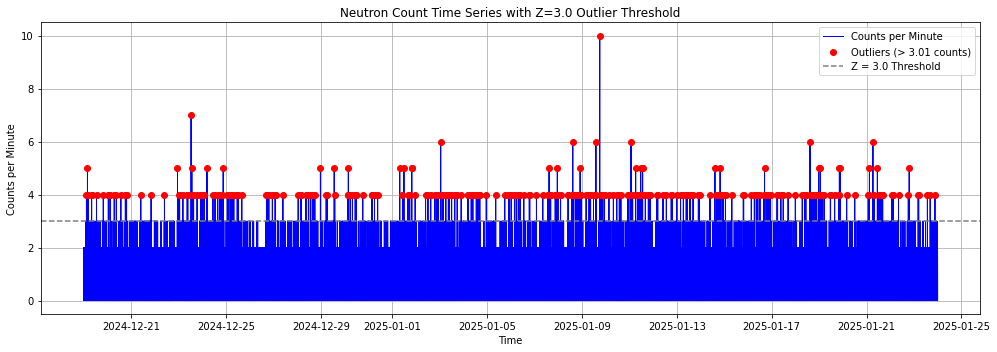

3.005064723189387

In [18]:
plot_outliers(Z=3)

## Step 2 - Accounting for Multiple Comparisons (Family-Wise Error Rate)

When you scan a long time series for outliers, each minute’s count is a separate hypothesis test (“is this minute an outlier?”).  If you keep using a fixed 3 σ threshold (per-test α≈0.00135), then over $N$ independent minutes your **family-wise error rate** (FWER) grows:

$$
\text{FWER} = 1 - (1 - \alpha)^N \approx N \cdot \alpha \quad (\text{for small }\alpha).
$$

For example, over a 1 day background run $(N≈1440$ minutes),  
$$
\text{FWER} \approx 1440 \times 0.00135 ≈ 1.94,
$$
i.e. almost certain to see at least one “false” 3 σ outlier just by chance.

Let's look into a possible solution for this issue: ?

### Bonferroni Correction

A simple (but conservative) fix is the **Bonferroni correction**, which sets the per-test α to  
$$
\alpha_{\rm per-test} = \frac{\alpha_{\rm family}}{N},
$$
so that  
$$
\text{FWER} \;\le\; N \times \alpha_{\rm per-test} = \alpha_{\rm family}.
$$  
If you want $\mathrm{FWER}=0.05$ over $N=1440$ minutes, then  
$$
\alpha_{\rm per-test} = \frac{0.05}{1440} \approx 3.5\times10^{-5},
$$
which corresponds to a threshold  
$$
Z_{\rm adj} = \Phi^{-1}(1 - \tfrac12\,\alpha_{\rm per-test}) \approx 4.0,
$$
i.e. roughly a 4 σ cut instead of 3 σ.


## New method for Visualizing Pointwise Poisson Probabilities

Rather than just flagging a binary outlier, we can compute for each 1-minute count $k$ its exact tail-probability under Poisson$(\lambda)$:

$$
p_k = P(\,K\ge k\,) \;=\; 1 - F(k-1;\lambda),
$$

and then plot $\log_{10}(p_k)$ against time.  This tells you at a glance how unlikely each point is, without choosing a hard $Z$.

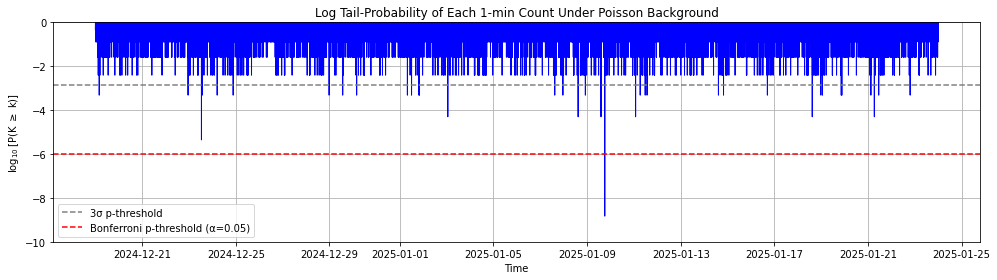

In [22]:
# λ from long-term background
lambda_ = neutron_df_1_minute_background["Counts"].mean()

# Compute tail-probabilities and log10
counts = neutron_df_1_minute_background["Counts"].values.astype(int)
p_tail = 1 - poisson.cdf(counts - 1, mu=lambda_)
log_p = np.log10(p_tail)

# Plot log10(p-value) time series
plt.figure(figsize=(14, 4))
plt.plot(neutron_df_1_minute_background.index, log_p, lw=1, color='blue')
plt.axhline(np.log10(0.00135), color='gray', linestyle='--', label='3σ p-threshold')
plt.axhline(np.log10(0.05/len(counts)), color='red', linestyle='--',
            label='Bonferroni p-threshold (α=0.05)')
plt.ylim(-10, 0)
plt.xlabel("Time")
plt.ylabel(r"$\log_{10}$[P(K $\geq$ k)]")
plt.title("Log Tail-Probability of Each 1-min Count Under Poisson Background")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpreting the Log Tail-Probability Plot

Once we’ve computed for each one-minute count \(k\) its exact tail probability under \(\mathrm{Poisson}(\lambda)\),

$$
p_k \;=\; P(K \ge k)
\;=\; 1 - F(k-1; \lambda),
$$

we ploted $\log_{10}(p_k)$ versus time above.  Here are a few notes on how to rea the above plot:

- **Y-axis ($\log_{10} p_k$).**  A value of $-2.9$ corresponds to $p_k \approx 10^{-2.9} \approx 1.26\times10^{-3}$, the usual $3 \sigma$ tail.  A value of $-6.3$ is roughly $10^{-6.3}\approx5\times10^{-7}$, the Bonferroni-adjusted threshold for $\mathrm{FWER}=0.05$ over $N\approx1440$ tests.
- **Lower bars = more improbable events.**  The deeper a bar drops below a horizontal threshold line, the more statistically significant that burst is.
- **No binary cutoff needed.**  You can instantly compare “how unlikely” each burst is, rather than just seeing “yes/no” flags.
- **Example extreme burst.**  Notice around 2025-01-09 there’s a point at $\log_{10} p_k \approx -9$.  That implies  
  $$
    p_k \approx 10^{-9},
  $$
  i.e.\ one chance in a billion—far beyond either the $3\sigma$ or Bonferroni $4\sigma$ cut: strongly suggesting a genuine anomaly from background (upon further analysis by taking a look at this specific waveform, this correspondeded to an instrumental glitch).

This visualization thus gives a continuous measure of surprise for every data point, highlights the most extreme outliers, and shows at a glance how they compare against any desired significance level.


Let us now perform the same analysis for gamma counts.

In [20]:
# Precompute Poisson mean for gamma background
lambda_gamma = gamma_df_1_minute_background["Counts"].mean()

# Define the plotting function
def plot_gamma_outliers(Z):
    threshold_poisson = lambda_gamma + Z * np.sqrt(lambda_gamma)
    poisson_outliers = gamma_df_1_minute_background[gamma_df_1_minute_background["Counts"] > threshold_poisson]

    plt.figure(figsize=(14, 5))
    plt.plot(gamma_df_1_minute_background.index, gamma_df_1_minute_background["Counts"],
             label="Gamma Counts per Minute", color='purple', linewidth=1)

    plt.scatter(poisson_outliers.index, poisson_outliers["Counts"],
                color='orange', label=f"{len(poisson_outliers)} Outliers (> {threshold_poisson:.2f} counts)", zorder=5)

    plt.axhline(threshold_poisson, color='gray', linestyle='--', linewidth=1.5,
                label=f"Z = {Z} Threshold")

    plt.title(f"Gamma Count Time Series with Z={Z} Outlier Threshold")
    plt.xlabel("Time")
    plt.ylabel("Gamma Counts per Minute")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Similarly to above, feel free to play around with $Z$ to observe the effect of its value on our count threshold.

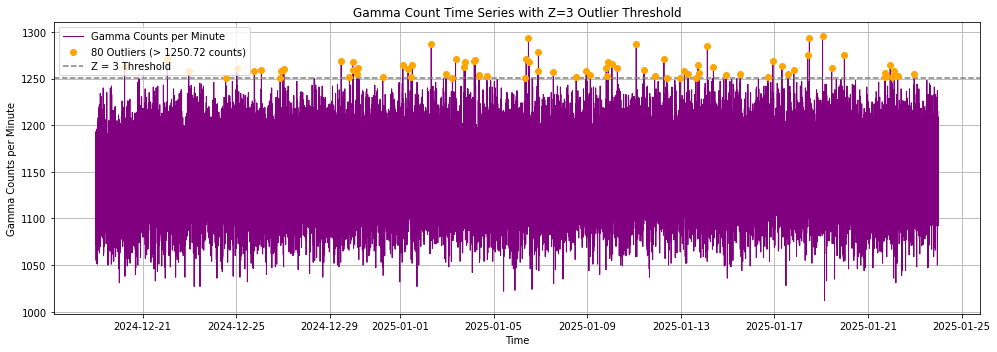

In [21]:
plot_gamma_outliers(Z=3)